# Finger People experimental playground

In [1]:
import numpy as np
import cv2
import os
import math
from helpers import imshow


## Input Sources
### Video file

In [2]:
cap = cv2.VideoCapture('samples/all_moves_1_180.mp4') 

# all_moves_1 sizes: 360, 180, 90, 46

### Camera

In [81]:
cap = cv2.VideoCapture(1)

# reduce frame size to speed it up
w = 180
h = w * 3/4
cap.set(cv2.CAP_PROP_FRAME_WIDTH, w) 
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, h) 
cap.set(cv2.CAP_PROP_FPS, 60)


True

## Optical Flow of Hand
#### Skin Detection Helpers

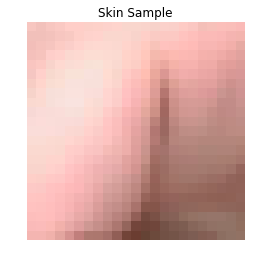

(0.0, 27.0, 101.0) (10.0, 138.0, 255.0)


In [69]:
# HSV ranges for skin detection  
skin_hsv_lower = np.array([0,  24,  80 ], dtype = "uint8")
skin_hsv_upper = np.array([20, 120, 255], dtype = "uint8")

def hsv_mask(img, lower, upper):
    '''
    Given a BGR image, returns a mask of pixels within lower and upper HSV space
    
    mask = hsv_mask(img, lower, upper)
    
    input
        img: A BGR image
        lower: 3-tuple with hue, saturation, and value of lower cutoff of mask
        upper: 3-tuple with hue, saturation, and value of upper cutoff of mask
        
    output
        mask: binary mask of pixels with HSV values between lower and upper
    '''
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = np.zeros((img.shape[:2]), dtype=np.uint8)
    
    if lower[0] > upper[0]:
        # To account for hue wrapping around 180 to 0
        lower_middle = (180, upper[1], upper[2])
        upper_middle = (0,   lower[1], lower[2])
        
        mask_lower = cv2.inRange(hsv, lower, lower_middle)
        mask_upper = cv2.inRange(hsv, upper_middle, upper)
        
        mask = mask_lower + mask_upper
        
    else:
        mask = cv2.inRange(hsv, lower, upper)
    
    return mask

def get_roi_sample(cap):
    '''
    Draws a rectangle on the screen
    Returns the pixels in the region upon pressing space
    '''
    _ret, frame = cap.read()
    h = frame.shape[0]
    w = frame.shape[1]
    p0 = (int(w/2-h/16), int(h/2-h/16))
    p1 = (int(w/2+h/16), int(h/2+h/16))
    
    while cap.isOpened():
        _ret, frame = cap.read()
        frame = cv2.flip(frame, 1)  
        
        if not _ret:
            break
            
        frame_display = frame.copy()
        cv2.rectangle(frame_display, p0, p1, (0,255,0), 2)
        cv2.imshow('frame', frame_display)
        
        key = cv2.waitKey(5)
        if key == ord(' '):
            break
            
    box_sample = frame[p0[1]:p1[1], p0[0]:p1[0]]
    return box_sample

def get_hsv_range(img):
    '''
    min_hsv, max_hsv = get_hsv_range(img)
    
    Finds and returns the bounds of hsv in an image.
    Shifts hue such that blue is around the 180/0 border 
    so that skin range can be easily evaluated
    
    Input
        img: bgr image
    
    Output
        min_hsv: 3-tuple containing the mininum hue, saturation, and value found in img
        max_hsv: 3-tuple containing the maximum hue, saturation, and value found in img
    '''
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    hue = img[:,:,0]
    sat = img[:,:,1]
    val = img[:,:,2]
    
    hue = (hue + 90)%180 # shift skin hues away from the 180/0 border
    min_hue, max_hue, _, _ = cv2.minMaxLoc(hue)
    min_hue = (min_hue - 90)%180
    max_hue = (max_hue - 90)%180
    
    min_sat, max_sat, _, _ = cv2.minMaxLoc(sat)
    min_val, max_val, _, _ = cv2.minMaxLoc(val)
    
    return (min_hue, min_sat, min_val), (max_hue, max_sat, max_val)


sample = get_roi_sample(cap)
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)
imshow(sample, 'Skin Sample')

min_hsv, max_hsv = get_hsv_range(sample)
print(min_hsv, max_hsv)

### Finger People

In [82]:
#cap = cv2.VideoCapture('samples/all_moves_1_180.mp4') 

MIN_BLOB_SIZE = 200
mhi_alpha = 0.75

# Parameters for farneback optical flow
fb_params = dict( pyr_scale = 0.5, 
                  levels = 3, 
                  winsize = 5, 
                  iterations = 3, 
                  poly_n = 5,
                  poly_sigma = 1.2, 
                  flags = 0 )

# Take the first frame
_ret, init_frame = cap.read()
prvs = cv2.cvtColor(init_frame,cv2.COLOR_BGR2GRAY)
frame1 = cv2.flip(init_frame, 1)

# For color representation of optical flow
flow_vis = np.zeros_like(init_frame)
flow_vis[...,1] = 255

# Motion history image
mag_hist = np.zeros((init_frame.shape[:2]), dtype=np.float32)
ang_hist = np.zeros((init_frame.shape[:2]), dtype=np.float32)
mhi = np.zeros_like(init_frame)
mhi[...,1] = 255

while cap.isOpened():
    
    # Get the next frame
    _ret, frame = cap.read()
    frame = cv2.flip(frame, 1)  
    if not _ret:
        break
        
    ''' SKIN MASK '''
    skin_mask = hsv_mask(frame, skin_hsv_lower, skin_hsv_upper)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel, iterations = 2)
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel, iterations = 2)
    
    im, contours, hierarchy = cv2.findContours(skin_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    lowest_contour = None
    lowest_contour_height = math.inf
    for i, contour in enumerate(contours):
        
        if cv2.contourArea(contour) >= MIN_BLOB_SIZE:
            
            # Find the lowest contour (that should be the hand, not face)
            m = cv2.moments(contour)
            contour_height = m['m10']/m['m00']
            
            if contour_height < lowest_contour_height:
                lowest_contour = i
                lowest_contour_height = contour_height
            
    # Draw in hand blob
    hand_mask = np.zeros_like(skin_mask)
    if lowest_contour:
        cv2.drawContours(hand_mask, contours, lowest_contour, 255, -1)

    ''' OPTICAL FLOW '''
    next = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

    flow = cv2.calcOpticalFlowFarneback(prvs, next, None, **fb_params)
    mag, ang = cv2.cartToPolar(flow[...,0], flow[...,1])
    
    # Ignore non-hand movement
    #mag = cv2.bitwise_and(mag, mag, mask=hand_mask)    
       
    ''' MHI '''
    mag_hist = mhi_alpha*mag_hist + (1-mhi_alpha)*mag
    ang_hist = mhi_alpha*ang_hist + (1-mhi_alpha)*ang
    mhi[...,0] = ang_hist*180/np.pi/2
    mhi[...,2] = cv2.normalize(mag_hist, None, 0, 255, cv2.NORM_MINMAX)

    ''' OUTPUT/DEBUG '''
    hand_mask = cv2.cvtColor(hand_mask, cv2.COLOR_GRAY2BGR)
    
    # Create color representation of optical flow
    flow_vis[...,0] = ang*180/np.pi/2
    flow_vis[...,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    flow_vis_bgr = cv2.cvtColor(flow_vis,cv2.COLOR_HSV2BGR)
    
    # Create color representation of mhi
    mhi_bgr = cv2.cvtColor(mhi, cv2.COLOR_HSV2BGR)
    
    cv2.imshow('frame',np.hstack((frame, cv2.cvtColor(skin_mask, cv2.COLOR_GRAY2BGR), flow_vis_bgr, mhi_bgr)))

    # Exit on ESC
    key = cv2.waitKey(5) & 0xFF
    if key == 27:
        break
    if key == ord('q'):
        break

    prvs = next
        
cap.release()
cv2.destroyAllWindows()
cv2.waitKey(1)


-1